In [1]:
# import dependencies
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
from scipy import interpolate, stats
import pandas as pd
import utils.readin_utils as readin

# matplotlib config
%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'dpi' : 100} #plotting pretty

In [2]:
# Settings for Analysis

# settings for exlusion
minimum_dim = 1000

# settings for contour plots
c_cmap = 'brg' # colormap for contour plots
c_levels = np.array([0.9, 0.8, 0.6, 0.3, 0.1]) # energy percentages to contour
interp_val = 5

# settings for calcuations
alpha_a_fitrange = [0.02, 0.35] 

number of aca images: 47
min aca image height: 1019
min aca image width: 1080
number of naca images: 29
min naca image height: 1003
min naca image width: 1152


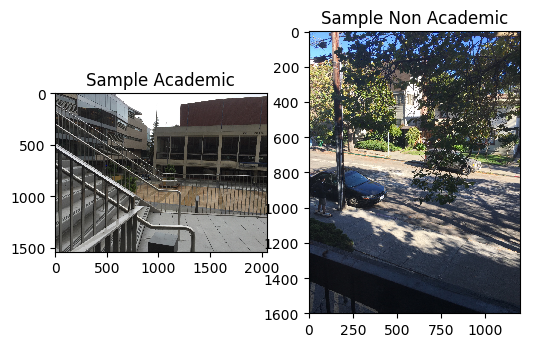

In [3]:
# Read our photo files
aca_datadir = './data/**/*Pano*/*AP*/**'
naca_datadir = './data/**/*Pano*/*NA*/**'
both_datadir = './data/**/'

aca_image_files = readin.readin_jpgs(aca_datadir)
naca_image_files = readin.readin_jpgs(naca_datadir)
image_files = aca_image_files + naca_image_files

try:
    raw_images
except NameError:
#if(1):
    raw_images, raw_flist, min_h, min_w = readin.read_ims(image_files, minimum_dim)
    aca_raw_images, aca_raw_flist, aca_min_h, aca_min_w = readin.read_ims(aca_image_files, minimum_dim)
    naca_raw_images, naca_raw_flist, naca_min_h, naca_min_w = readin.read_ims(naca_image_files, minimum_dim)
    #use less of height and width to make samples square
    min_dim = min(aca_min_h, aca_min_w, naca_min_h, naca_min_w)
    
plt.subplot(1, 2, 1, title="Sample Academic")
plt.imshow(aca_raw_images[0])

print('number of aca images: {}'.format(np.shape(aca_raw_images)[0]))
print('min aca image height: {}'.format(aca_min_h))
print('min aca image width: {}'.format(aca_min_w))

plt.subplot(1, 2, 2, title="Sample Non Academic")
plt.imshow(naca_raw_images[0])

print('number of naca images: {}'.format(np.shape(naca_raw_images)[0]))
print('min naca image height: {}'.format(naca_min_h))
print('min naca image width: {}'.format(naca_min_w))


In [4]:
# read in axial lengths
aca_xls = './data/Non Academic Period Master Spreadsheet 8.13.15 .xlsx'
nonaca_xls = './data/Academic Period Master Spreadsheet 8.13.15 .xlsx'

aca_als = readin.readin_al_xls(aca_xls)
aca_als.columns = ['ACA OD AL','ACA OS AL']
naca_als = readin.readin_al_xls(nonaca_xls)
naca_als.columns = ['NACA OD AL','NACA OS AL']

# combine to one spreadsheet
als = pd.concat([aca_als,naca_als],axis=1)
al_subjects = als.index

#get a subject list that only contains those with images we will analyze BADASS double list comprehension
subjects = np.unique([sub for sub in list(al_subjects) for file in raw_flist if sub in file])

# Print table
print(als) 

          ACA OD AL ACA OS AL NACA OD AL NACA OS AL
AG102816        NaN       NaN      24.18      24.29
AH110515      23.06     23.09      23.16      23.17
AL100115        NaN       NaN       25.6      25.14
AN120915      25.16     25.46      25.15       25.5
CB030217        NaN       NaN      23.31      23.17
CH121015         25     25.41        NaN        NaN
CL021617        NaN       NaN      24.72      24.94
CM021816        NaN       NaN      25.07      25.08
DC080615      24.21     24.15        NaN        NaN
DG110915        NaN       NaN      23.98      23.69
DH030317        NaN       NaN      23.16      23.47
GG073115      23.75     23.87        NaN        NaN
GJ041316        NaN       NaN      24.19      24.19
HL110215      25.11     24.85      25.05      24.88
HM110316        NaN       NaN      21.83      21.77
IK030117        NaN       NaN      24.75      24.67
JC101615      22.96      23.1      22.86      23.03
JC102715      26.26     26.42      26.22      26.35
JC110615    

In [5]:
def cropims(ims, crop_h, crop_w, area, lr_replicates=False):
    h_crop_h = np.int(crop_h/2)
    h_crop_w = np.int(crop_w/2)
    # newims = np.ones((np.shape(ims)[0],crop_h,crop_w,3))
    newims = []
    for i, im in enumerate(ims):
        # print(np.shape(im))
        im_h = np.shape(im)[0]
        im_w = np.shape(im)[1]
        h_im_h = np.int(im_h / 2) # half image height
        h_im_w = np.int(im_w / 2) # half image width
        
        #check to see if we have large enough images to crop
        if(im_w < 2*crop_w):
            lr_replicates=False
        
        if(area=='middle'):
            newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                       h_im_w - h_crop_w:h_im_w + h_crop_w+1, # crop width
                       :]  
            if(np.shape(newim)[0]==0):
                print(h_im_h)
                print(h_crop_h)
                print(np.shape(im))
            #print('mid{}'.format(np.shape(newim)))
            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[h_im_h - h_crop_h:h_im_h + h_crop_h+1, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]

                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_mid{}'.format(np.shape(l_newim)))
                #print('right_mid{}'.format(np.shape(r_newim)))


        elif(area=='top'):
            newim = im[0:crop_h, # crop height
                       h_im_w - h_crop_w-1:h_im_w + h_crop_w, # crop width
                       :]
            #print('top{}'.format(np.shape(newim)))

            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[0:crop_h, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[0:crop_h, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]
                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_top{}'.format(np.shape(l_newim)))
                #print('right_top{}'.format(np.shape(r_newim)))

            
        elif(area=='bottom'):
            newim = im[im_h - crop_h:im_h, # crop height
                       h_im_w - h_crop_w-1:h_im_w + h_crop_w, # crop width
                       :]
            #print('but{}'.format(np.shape(newim)))

            newims.append(newim)
            #also add replicates
            if(lr_replicates):
                l_newim = im[im_h - crop_h:im_h, # crop height
                           0:crop_w, # crop width
                           :]
                r_newim = im[im_h - crop_h:im_h, # crop height
                           im_w-crop_w:im_w, # crop width
                           :]
                
                newims.append(l_newim)
                newims.append(r_newim)
                #print('left_but{}'.format(np.shape(l_newim)))
                #print('right_but{}'.format(np.shape(r_newim)))

        else:
            raise ValueError('area not well specified!')
        
    return(newims)

def avgims(ims):
    ims_arr = np.array(ims)
    # average images  - first index must be list of images
    avg = np.zeros_like(ims_arr[0])
    # print(np.shape(avg))
    for c in range(np.shape(avg)[2]): # loop over R, G, and B
        avg[:, :, c] = np.mean(ims_arr[:, :, :, c], axis=0)
    return(avg)

def spatialft(image):
    """Take the fourier transform of the image.
    shift the quadrants around so that low spatial frequencies are in
    the center of the 2D fourier transformed image"""
    
    greyavgim = np.mean(np.asarray(image),axis=2)  # average over colors
    greyavgim =  greyavgim - np.mean(greyavgim)  # remove DC component
    ft = np.abs(np.fft.fftshift(np.fft.fft2(greyavgim)))
    fqs = [np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[0])),
           np.fft.fftshift(np.fft.fftfreq(np.shape(greyavgim)[1]))]
    ps = ft**2
    return(greyavgim, ft, ps, fqs)

def get_logspace_contours(raw_field, c_levels=c_levels):
    """Get the contour locations by percentage"""
    log_field = np.log10(raw_field)
    field = log_field / log_field.sum()
    n = 1000
    t = np.linspace(0, field.max(), n)
    integral = ((field >= t[:, None, None]) * field).sum(axis=(1, 2))
    f = interpolate.interp1d(integral, t)
    
    t_contours = f(c_levels) * log_field.sum()
    linear_t_contours = 10**t_contours
    
    return(linear_t_contours)

def fit_alpha_as(set_ims, direction):
    
    set_avgim = avgims(set_ims)
    
    # 1/f function to fit
    def feq(cpd, a, alpha):
        amp = a / (cpd**alpha)
        return(amp)
    
    # data to fit function to
    minfit = alpha_a_fitrange[0]
    maxfit = alpha_a_fitrange[1]
    
    # initialize values
    xs = []
    ys = []
    
    # cacluate ft and fit values for each image, so we have many points to fit
    for i, im in enumerate(set_ims):
        # normalize our image
        normim = im / np.max(set_avgim)
        
        # calculate the fourier transform
        im_bw, ft2d, ps2d, fqs = spatialft(normim)
        
        if(direction == 'vertical'):
            # which VERTICAL frequency is closest to the min we want (index)?
            minfq = np.abs(fqs[1] - minfit).argmin()
            # which VERTICAL frequency is closest to the max we want (index)?
            maxfq = np.abs(fqs[1] - maxfit).argmin()
            # add our values for VERTICAL frequencies between these limits
            xs.append(fqs[1][minfq:maxfq])
            # add our values for VERTICAL fourier amps in this limit
            ys.append(ft2d[int(np.shape(ft2d)[0]/2),minfq:maxfq])

        elif(direction == 'horizontal'):
            # index of horiz frequency closest to range
            minfq = np.abs(fqs[0] - minfit).argmin()
            # index of horiz frequency closest to range
            maxfq = np.abs(fqs[0] - maxfit).argmin()
            # horiz fqs in these limits
            xs.append(fqs[0][minfq:maxfq])
            # hoirz fourier amps in range
            ys.append(ft2d[minfq:maxfq, int(np.shape(ft2d)[1] / 2)])
            
        elif(direction == 'skew'):
            # use x index here [0] to ensure same size
            skewfqs = np.sqrt(np.add(fqs[0][-int(np.shape(ft2d)[0]/2):]**2,
                                     fqs[1][-int(np.shape(ft2d)[0]/2):]**2))
            # skew frequncies diagonally out from middle by pythagorean therom ASSUME EQUALLY SPACED
            # index of skew fq closest to range
            minfq = np.abs(skewfqs - minfit).argmin()
            # index of skew fq closest to range
            maxfq = np.abs(skewfqs - maxfit).argmin()

            for angle in [45,135]:
                xs.append(skewfqs[minfq:maxfq])
                if(45):
                    # start from middle to measure y fqs
                    ys.append(np.diagonal(ft2d[int(np.shape(ft2d)[0]/2) + minfq:int(np.shape(ft2d)[0]/2) + maxfq,
                                               int(np.shape(ft2d)[1]/2) + minfq:int(np.shape(ft2d)[1]/2) + maxfq]))
                else:
                    ft2d_flip = np.fliplr(ft2d) #flip indexes to get the 135 degree angle
                    ys.append(np.diagonal(ft2d_flip[int(np.shape(ft2d_flip)[0]/2) + minfq:int(np.shape(ft2d_flip)[0]/2) + maxfq,
                                               int(np.shape(ft2d_flip)[1]/2) + minfq:int(np.shape(ft2d_flip)[1]/2) + maxfq]))       
        else:
            raise NameError('no recognized direction specified to fit a and alpha!')
        
        # fit
        [a, alpha], cov = scipy.optimize.curve_fit(feq,
                                                  np.array(xs).flatten(),
                                                  np.array(ys).flatten())
        # convert to 1SD
        [a_se, alpha_se] = np.sqrt(np.diag(cov))

    return(a, a_se, alpha, alpha_se)


def interp_get_contours(ps):
    interp = scipy.ndimage.filters.gaussian_filter(ps, interp_val)
    contours = get_logspace_contours(interp)
    return(interp, contours)

def contour_plotter(ps, fqs, bar=True, ticks=True):
    """Function to make contour plots"""
    interp, contours = interp_get_contours(ps)
    cont_pl = plt.pcolormesh(fqs[1],
                             fqs[0],
                             interp,
                             cmap="gray",
                             norm=mpl.colors.LogNorm())#,extent=extents)
    
    if(bar):
        cont_pl = plt.colorbar()
        
    if not(ticks):
        plt.axis('off')
    
    pl = plt.contour(fqs[1],
                     fqs[0],
                     interp,
                     levels=contours,
                     cmap=c_cmap,
                     norm=mpl.colors.LogNorm())
    return(pl)


def implot(im):
    pl = plt.imshow(im)
    pl = plt.axis('off')

def analyze_imset(set_ims,min_dim,dictloc):
    
    for loc in ['top', 'middle', 'bottom']:
        dictloc[loc] = {}

        # calculate cropped version of images
        cropped = cropims(ims=set_ims,
                          crop_h=min_dim,
                          crop_w=min_dim,
                          area=loc,
                          lr_replicates = True)
        #for c in cropped:
        #    print(np.shape(c))
        dictloc[loc]['images'] = cropped

        # calculate average image
        dictloc[loc]['avgim'] = avgims(dictloc[loc]['images'])
        # calcuate FT & PS
        fft_results = spatialft(dictloc[loc]['avgim'])
        dictloc[loc]['avgim_bw'] = fft_results[0]
        dictloc[loc]['avgim_fft'] = fft_results[1]
        dictloc[loc]['avgim_ps'] = fft_results[2]
        dictloc[loc]['avgim_fft_freqs'] = fft_results[3]

        # fit alpha & as for each dicretion
        for direction in ['horizontal', 'vertical','skew']:
            alpha_fits_h = fit_alpha_as(dictloc[loc]['images'],direction)
            dictloc[loc]['avgim_a_{}'.format(direction)] = alpha_fits_h[0]
            dictloc[loc]['avgim_a_se_{}'.format(direction)] = alpha_fits_h[1]
            dictloc[loc]['avgim_alpha_{}'.format(direction)] = alpha_fits_h[2]
            dictloc[loc]['avgim_alpha_se_{}'.format(direction)] = alpha_fits_h[3]
            
    return(dictloc)

In [6]:
# make a dictionary to organize our data better
ddict = {}

# summarize academic and non academic for ALL subjects
ddict['aca'] = {}
ddict['naca'] = {}
# add raw images to our dictionary
ddict['aca']['images_raw'] = aca_raw_images
ddict['naca']['images_raw'] = naca_raw_images
# analyze overall NACA and ACA
ddict['aca'] = analyze_imset(set_ims = aca_raw_images,
                             min_dim = min_dim,
                             dictloc = ddict['aca'])
ddict['naca'] = analyze_imset(set_ims = naca_raw_images,
                              min_dim = min_dim,
                              dictloc = ddict['naca'])

# analyze images for each individual subject
for i, sub in enumerate(subjects):
    
    # get lists of subject's images - must leave as list because they are different sizes
    aca_sub_idxs = [i for i, x in enumerate(aca_raw_flist) if sub in x]
    naca_sub_idxs = [i for i, x in enumerate(naca_raw_flist) if sub in x]
    aca_subims = [aca_raw_images[i] for i in aca_sub_idxs]
    naca_subims = [naca_raw_images[i] for i in naca_sub_idxs]
    sub_idxs = [i for i, x in enumerate(raw_flist) if sub in x]
    subims = [raw_images[i] for i in sub_idxs]
    
    # make a sub dictionary 
    ddict[sub] = {}
      
    # put AL values into dict
    ddict[sub]['AL'] = als.loc[sub]
    
    # analyze subject's overall images
    thisloc = ddict[sub]

    # if there are images in this category then calculate averages and ft for them
    if not np.shape(subims) == (0, ):
        ddict[sub] = analyze_imset(set_ims = subims,
                                min_dim = min_dim,
                                dictloc = thisloc)

    # analyze academic & nonacademic separately
    if not np.shape(aca_subims) == (0, ):
        school = 'aca'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = aca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc)
    if not np.shape(naca_subims) == (0, ):
        school = 'naca'
        ddict[sub][school] = {}
        ddict[sub][school]['images_raw'] = naca_subims
        #variable containing our position in dictionary
        thisloc = ddict[sub][school]
        #if there are images in this category then calculate averages and ft for them
        ddict[sub][school] = analyze_imset(set_ims = thisloc['images_raw'],
                                        min_dim = min_dim,
                                        dictloc = thisloc)
  
         

In [7]:
print(ddict.keys())

dict_keys(['aca', 'naca', 'AH110515', 'CM021816', 'DC080615', 'HL110215', 'HM110316', 'JC101615', 'JC110615', 'JH091715', 'JN110915', 'LW072415', 'MC110416', 'ML072115', 'NS091015', 'PS102015', 'SB101416', 'SG021116', 'SZ091115', 'TE072715', 'VP041416'])


dict_keys(['images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew'])


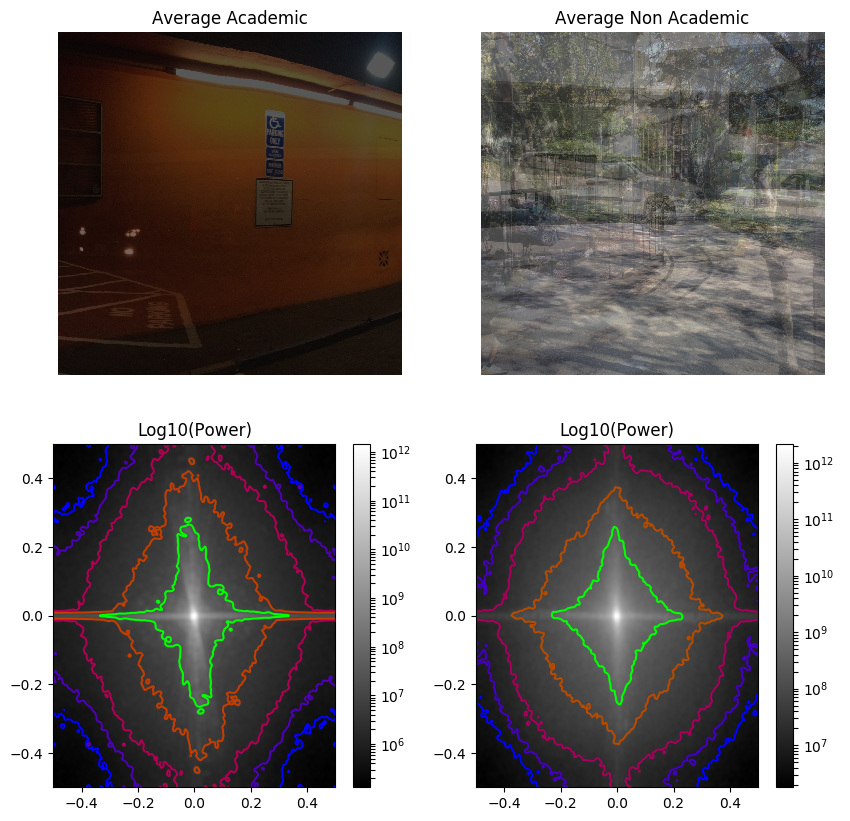

In [11]:
#plot a few example images

sample_sub = 'HL110215'
sample_loc = 'middle'

print(ddict[sample_sub]['aca'][sample_loc].keys())

plt.figure(figsize=(10,10))

plt.subplot(2, 2, 1, title="Average Academic")
implot(ddict[sample_sub]['aca'][sample_loc]['avgim'])


plt.subplot(2, 2, 2, title="Average Non Academic")
implot(ddict[sample_sub]['naca'][sample_loc]['avgim'])

plt.subplot(2, 2, 3, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['aca'][sample_loc]['avgim_ps'],
                fqs = ddict[sample_sub]['aca'][sample_loc]['avgim_fft_freqs'],
                bar=True)

plt.subplot(2, 2, 4, title='Log10(Power)')
contour_plotter(ps = ddict[sample_sub]['naca'][sample_loc]['avgim_ps'],
                fqs = ddict[sample_sub]['naca'][sample_loc]['avgim_fft_freqs'],
                bar=True)

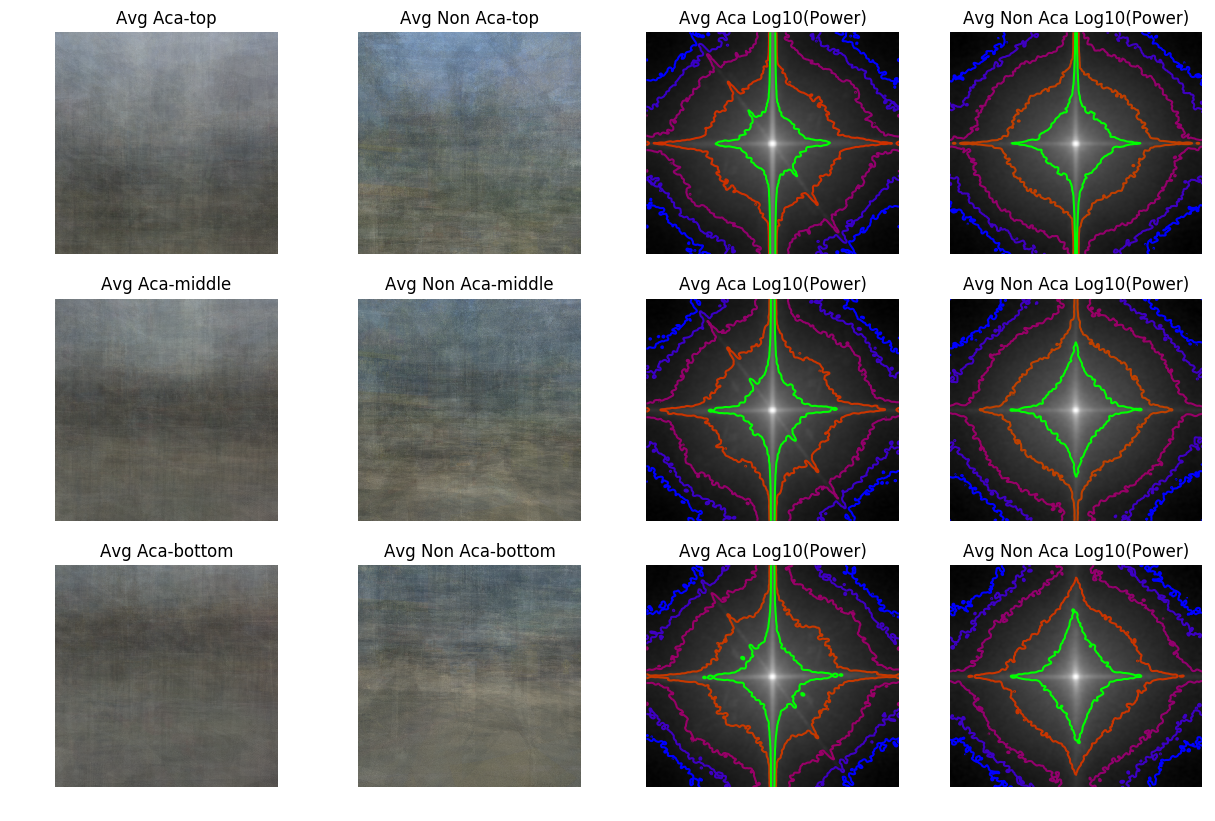

In [12]:
#plot the average for top middle and bottom comparing academic and non-academic

plt.figure(figsize=(15,10))

for i, sample_loc in enumerate(['top','middle','bottom']):

    ax = plt.subplot(3, 4, 1+(4*i), title="Avg Aca-{}".format(sample_loc))
    implot(ddict['aca'][sample_loc]['avgim'])

    ax = plt.subplot(3, 4, 2+(4*i), title="Avg Non Aca-{}".format(sample_loc))
    implot(ddict['naca'][sample_loc]['avgim'])

    ax = plt.subplot(3, 4, 3+(4*i), title='Avg Aca Log10(Power)')
    contour_plotter(ps = ddict['aca'][sample_loc]['avgim_ps'],
                    fqs = ddict['aca'][sample_loc]['avgim_fft_freqs'], bar=False, ticks=False)
    #ax.annotate('a_v='+str(np.round(ddict['aca'][sample_loc]['avgim_alpha_vertical'],2)),xy=(100,100))
    
    ax = plt.subplot(3, 4, 4+(4*i), title='Avg Non Aca Log10(Power)')
    contour_plotter(ps = ddict['naca'][sample_loc]['avgim_ps'],
                    fqs = ddict['naca'][sample_loc]['avgim_fft_freqs'], bar=False, ticks=False)

In [13]:
#make a pandas df to hold our data

fits_df = pd.DataFrame(columns = ('variable','direction','location','academic','value'))
i=0
for variable in ['a','a_se','alpha','alpha_se']:
    for location in ['top','middle','bottom']:
        for direction in ['vertical','horizontal','skew']:
            for academic in ['aca','naca']:
                value = ddict[academic][location]['avgim_{}_{}'.format(variable,direction)]
                fits_df.loc[i] = ([variable,direction,location,academic,value])
                i+=1
#a_alpha_fits_df

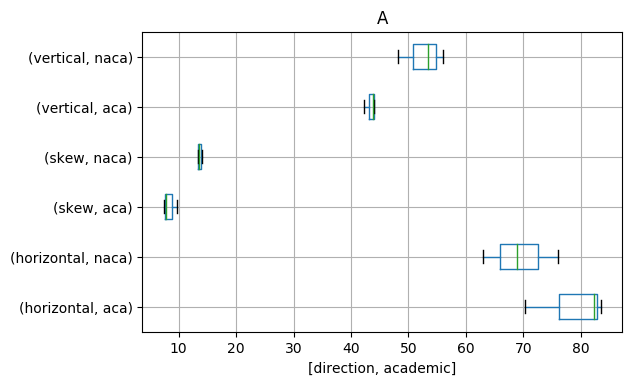

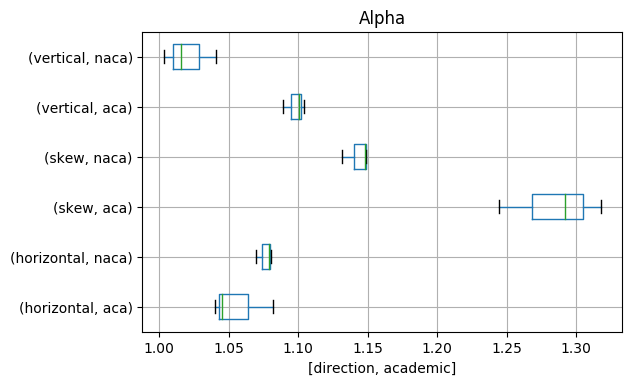

In [14]:
a = fits_df[(fits_df.variable == 'a')]
alpha = fits_df[(fits_df.variable == 'alpha')]

plt.figure(figsize=(10,20))
a.boxplot(by=['direction','academic'],vert=False)
plt.title('A')
plt.suptitle('')

alpha.boxplot(by=['direction','academic'],vert=False)
plt.title('Alpha')
plt.suptitle('')

In [15]:
a_middle = fits_df[(fits_df.variable == 'a')&(fits_df.location == 'middle')].set_index(['academic','direction'])
a_se_middle = fits_df[(fits_df.variable == 'a_se')&(fits_df.location == 'middle')].set_index(['academic','direction'])

alpha_middle = fits_df[(fits_df.variable == 'alpha')&(fits_df.location == 'middle')].set_index(['academic','direction'])
alpha_se_middle = fits_df[(fits_df.variable == 'alpha_se')&(fits_df.location == 'middle')].set_index(['academic','direction'])

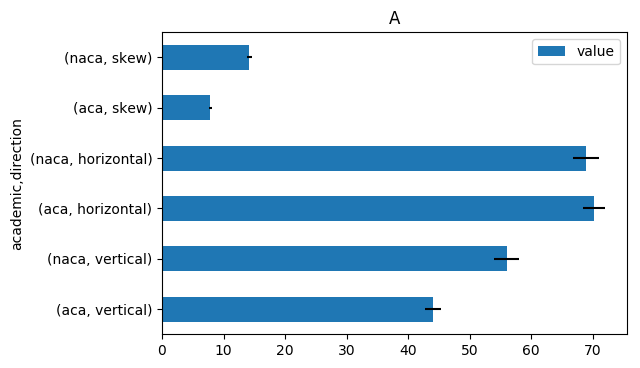

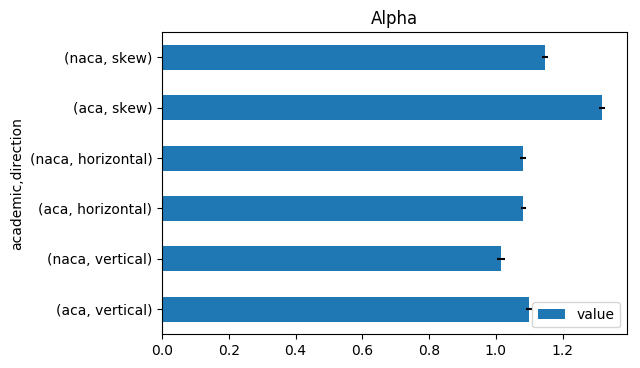

In [16]:
a_middle.plot(xerr = a_se_middle,title='A',kind='barh')
alpha_middle.plot(xerr = alpha_se_middle,title='Alpha',kind='barh')

In [17]:
ddict['aca']['top'].keys()

dict_keys(['images', 'avgim', 'avgim_bw', 'avgim_fft', 'avgim_ps', 'avgim_fft_freqs', 'avgim_a_horizontal', 'avgim_a_se_horizontal', 'avgim_alpha_horizontal', 'avgim_alpha_se_horizontal', 'avgim_a_vertical', 'avgim_a_se_vertical', 'avgim_alpha_vertical', 'avgim_alpha_se_vertical', 'avgim_a_skew', 'avgim_a_se_skew', 'avgim_alpha_skew', 'avgim_alpha_se_skew'])

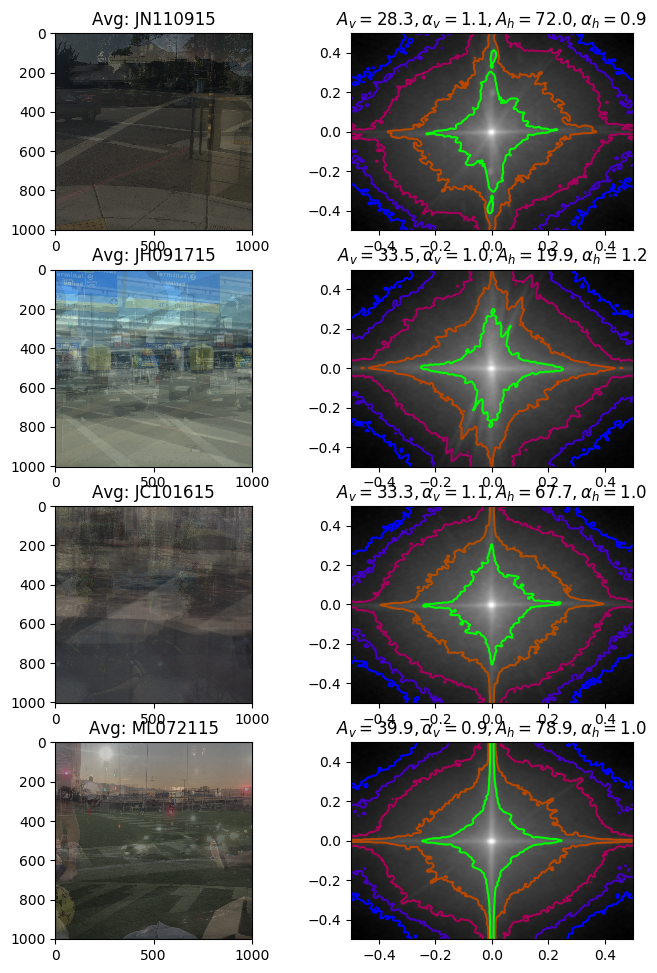

In [18]:
#plot 2d power spectra for n random subjects

n=4
trs = np.random.choice(subjects,n,replace=False)

plt.subplots(nrows=2,ncols=n,figsize =(8,n*3))

for i in range(n):

    sub = trs[i]
    plt.subplot(n,2,2*i+1, title='Avg: {}'.format(sub))
    plt.imshow(ddict[sub][sample_loc]['avgim'], interpolation='none',cmap='gray')
    plt.subplot(n,2,2*i+2,
                title=r'$A_v={0:.1f},\alpha_v={1:.1f},A_h={2:.1f},\alpha_h={3:.1f}$'.format(ddict[sub][sample_loc]['avgim_a_vertical'],
                                                                                            ddict[sub][sample_loc]['avgim_alpha_vertical'],
                                                                                            ddict[sub][sample_loc]['avgim_a_horizontal'], 
                                                                                            ddict[sub][sample_loc]['avgim_alpha_horizontal'])
                )

    contour_plotter(ddict[sub][sample_loc]['avgim_ps'],
                    fqs = ddict[sub][sample_loc]['avgim_fft_freqs'],
                    bar=False)
                    

In [19]:
subjects

array(['AH110515', 'CM021816', 'DC080615', 'HL110215', 'HM110316',
       'JC101615', 'JC110615', 'JH091715', 'JN110915', 'LW072415',
       'MC110416', 'ML072115', 'NS091015', 'PS102015', 'SB101416',
       'SG021116', 'SZ091115', 'TE072715', 'VP041416'], 
      dtype='<U8')

In [20]:
# compare A and Alpha with Axial Length

al_fits = pd.DataFrame(columns = ('subject','location','direction','a','a_se','alpha','alpha_se','AL_OD','AL_OS'))
    
i=0
for sub in subjects:
    for location in ['top','middle','bottom']:
        for direction in ['vertical','horizontal','skew']:
            a = ddict[sub][location]['avgim_a_{}'.format(direction)]
            a_se = ddict[sub][location]['avgim_a_se_{}'.format(direction)]
            alpha = ddict[sub][location]['avgim_alpha_{}'.format(direction)]
            alpha_se = ddict[sub][location]['avgim_alpha_se_{}'.format(direction)]
            al_od = np.mean(als.loc[sub][['NACA OD AL','ACA OD AL']])
            al_os = np.mean(als.loc[sub][['NACA OS AL','ACA OS AL']])
            al_fits.loc[i] = ([sub, location, direction, a, a_se, alpha, alpha_se, al_od, al_os])
            i+=1

,subject,location,direction,a,a_se,alpha,alpha_se,AL_OD,AL_OS
0,AH110515,top,vertical,30.376390,1.657350,1.121401,0.016640,23.110,23.130
1,AH110515,top,horizontal,80.789916,2.620855,0.992407,0.010202,23.110,23.130
2,AH110515,top,skew,6.547091,0.398098,1.231291,0.018043,23.110,23.130
9,CM021816,top,vertical,40.074503,2.829258,1.122948,0.021521,25.070,25.080
10,CM021816,top,horizontal,31.821594,2.030187,1.214374,0.019100,25.070,25.080
11,CM021816,top,skew,5.398201,0.396442,1.462133,0.021075,25.070,25.080
18,DC080615,top,vertical,37.434645,3.513787,1.113500,0.028668,24.210,24.150
19,DC080615,top,horizontal,56.722272,6.499040,1.146367,0.034762,24.210,24.150
20,DC080615,top,skew,6.551394,0.591111,1.184303,0.027003,24.210,24.150
27,HL110215,top,vertical,68.610755,4.766503,0.964224,0.022014,25.080,24.865


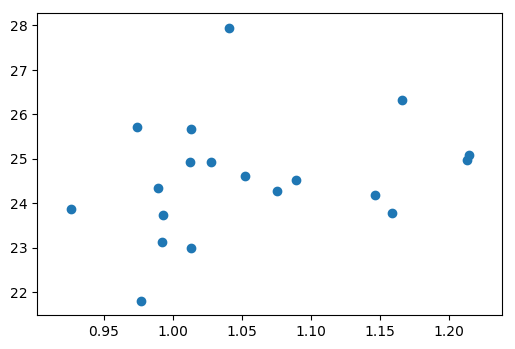

In [21]:
#Do this analysis for top, middle, or bottom crop
sampleloc = 'top'

al_fits_mid = al_fits[al_fits['location']==sampleloc]
#al_fits_mid = al_fits_mid.pivot(index='subject', columns='direction')
#al_fits_mid.stack()
al_mid_horiz = al_fits_mid[al_fits_mid['direction']=='horizontal']
plt.scatter(al_mid_horiz['alpha'], np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='horizontal')

al_fits_mid

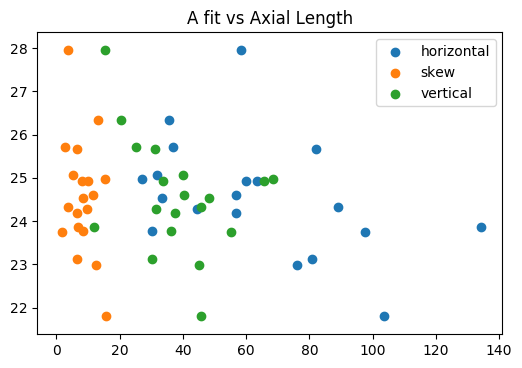

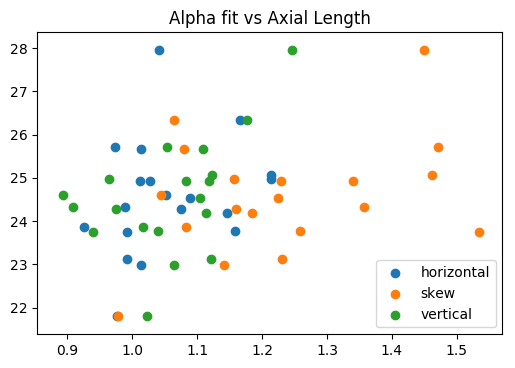

In [22]:
#plot a fits

al_mid_horiz = al_fits_mid[al_fits_mid['direction']=='horizontal']
plt.scatter(al_mid_horiz['a'], np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='horizontal')

al_mid_skew = al_fits_mid[al_fits_mid['direction']=='skew']
plt.scatter(al_mid_skew['a'], np.mean([al_mid_skew['AL_OD'],al_mid_skew['AL_OS']],axis=0),label='skew')

al_mid_vert = al_fits_mid[al_fits_mid['direction']=='vertical']
plt.scatter(al_mid_vert['a'], np.mean([al_mid_vert['AL_OD'],al_mid_vert['AL_OS']],axis=0),label='vertical')

plt.legend()
plt.title('A fit vs Axial Length')


#plot a
plt.figure()

plt.scatter(al_mid_horiz['alpha'], np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='horizontal')
plt.scatter(al_mid_skew['alpha'], np.mean([al_mid_skew['AL_OD'],al_mid_skew['AL_OS']],axis=0),label='skew')
plt.scatter(al_mid_vert['alpha'], np.mean([al_mid_vert['AL_OD'],al_mid_vert['AL_OS']],axis=0),label='vertical')

plt.legend()
plt.title('Alpha fit vs Axial Length')


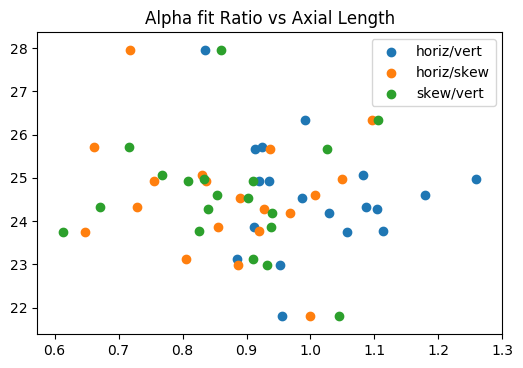

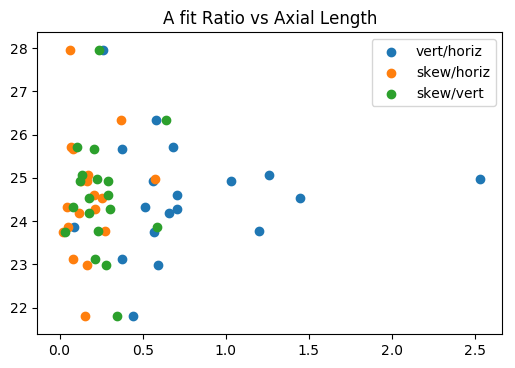

In [23]:
plt.scatter(np.divide(al_mid_horiz['alpha'],al_mid_vert['alpha']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='horiz/vert')
plt.scatter(np.divide(al_mid_horiz['alpha'],al_mid_skew['alpha']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='horiz/skew')
plt.scatter(np.divide(al_mid_vert['alpha'],al_mid_skew['alpha']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='skew/vert')
plt.legend()
plt.title('Alpha fit Ratio vs Axial Length')

plt.figure()
plt.scatter(np.divide(al_mid_vert['a'],al_mid_horiz['a']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='vert/horiz')
plt.scatter(np.divide(al_mid_skew['a'],al_mid_horiz['a']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='skew/horiz')
plt.scatter(np.divide(al_mid_skew['a'],al_mid_vert['a']), np.mean([al_mid_horiz['AL_OD'],al_mid_horiz['AL_OS']],axis=0),label='skew/vert')
plt.legend()
plt.title('A fit Ratio vs Axial Length')

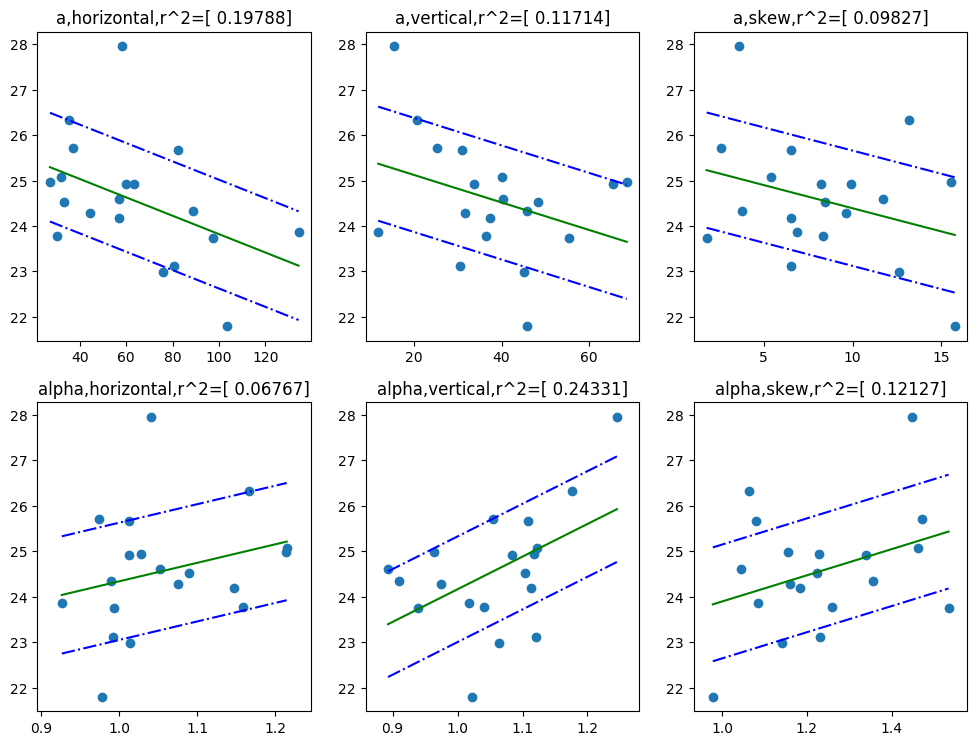

In [24]:
def regression_fitter(x,y,my_axes,val,direction):
    z = np.polyfit(x,y,deg=1,full=True)
    m_h = z[0][0]
    b_h = z[0][1]
    sse = z[1]#[0]
    rsq = 1-sse/np.sum((y-np.mean(y))**2)
    fit = np.array(m_h*x+b_h)
    err_h = np.abs(y-fit)
    se = np.sqrt(np.sum(err_h**2)/(len(x)-1))
    sem = se/np.sqrt(len(x))
    xlsp = np.linspace(np.min(x), np.max(x),50)
    ylsp = xlsp*m_h+b_h
    my_axes.plot(xlsp,ylsp,'g')
    my_axes.plot(xlsp,ylsp+se,'b-.')
    my_axes.plot(xlsp,ylsp-se,'b-.')
    my_axes.set_title('{},{},r^2={}'.format(val,direction,np.round(rsq,5)))
    return(my_axes)


fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in ['horizontal','vertical','skew']:
        #plot fits
        plt.figure()
        vals = al_fits_mid[al_fits_mid['direction']==direction]
        xs = vals[val]
        ys = np.mean([vals['AL_OD'],vals['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1



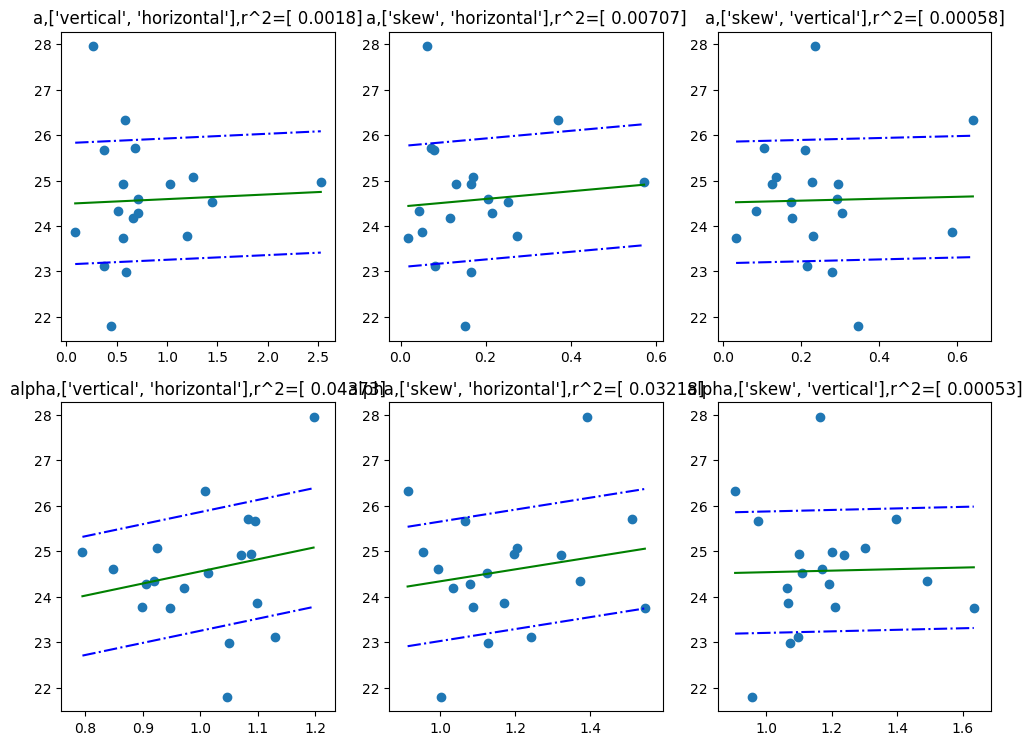

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize =(12,9))
ix = 0 #index columns
for val in ['a','alpha']:
    iy = 0 #index rows
    for direction in [['vertical','horizontal'],['skew','horizontal'],['skew','vertical']]:
        #plot fits
        plt.figure()
        vals_num = al_fits_mid[al_fits_mid['direction']==direction[0]]
        vals_denom = al_fits_mid[al_fits_mid['direction']==direction[1]]
        xs = np.divide(vals_num[val],vals_denom[val])
        ys = np.mean([vals_num['AL_OD'],vals_num['AL_OS']],axis=0)
        axes[ix,iy].scatter(xs, ys,label='horizontal')
        axes[ix,iy].xlabel = val
        axes[ix,iy] = regression_fitter(xs,ys,axes[ix,iy],val,direction)
        iy+=1
    ix+=1


In [ ]:
## Todo:

#Analyze ACA and NACA AL values separately? YES
#Compare these ALs to ACA and NACA photos separately? YES
#Group subjects into 'myopic' and 'non-myopic' and look for difference in groups rather than individually correlating? NO

# Notes from meeting with Elise:

measure images independently because As may not match or normalize somehow
individual differences are more imporant.

alpha difference value from aca to non aca for individual subjecgt

within acsdrmic period.

how mauch varation do individuals have in their values for alpha and a

how to top middle and bottom vary between each other for an individual subject?

dont take mean of both eyes. some are very different. Take longer eye val. %SUPER EASY

subsample large images instead of zooming in on large ones OR remove panaaramoics./ %TOP PRIOROTY